In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AR

from data_utils import read_data_from_file
from PACF import PACF

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import jarque_bera

from metrics import akkake_criteria, rmse, determination_coef, rsse, adjusted_det_coef, log_likelihood, mean_dependent_var, std_dependent_var, shwarz_criteria   
from statsmodels.stats.stattools import durbin_watson

In [2]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

# Read data

In [3]:
t_s = np.array(read_data_from_file('data/ARCH_01.dat'))

# Explore data

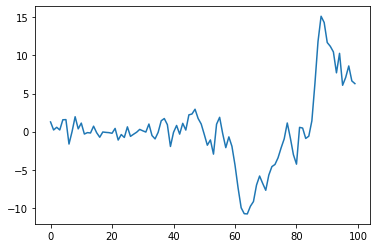

In [4]:
plt.plot(t_s)

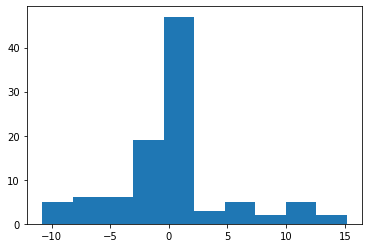

In [5]:
plt.hist(t_s);

In [6]:
t_s = pd.Series(t_s)

pd.Series(data=[t_s.mean(),
                 t_s.median(),
                 t_s.max(),
                 t_s.min(),
                 t_s.std(),
                 t_s.skew(),
                 t_s.kurtosis(),
                 jarque_bera(t_s)[0],
                 jarque_bera(t_s)[1]],
          index=['mean',
                 'median',
                 'max',
                 'min',
                 'std',
                 'skewness',
                 'kurtosis',
                 'jarque_bera',
                 'jarque_bera_prob'])

mean                 0.263369
median              -0.083150
max                 15.150000
min                -10.800000
std                  4.894091
skewness             0.565101
kurtosis             1.606938
jarque_bera         14.146152
jarque_bera_prob     0.000848
dtype: float64

In [7]:
t_s = np.array(t_s)

In [8]:
initial_t_s_pacf = PACF(t_s)

initial_t_s_pacf_r = [initial_t_s_pacf.simmetric_F(i) for i in range(len(t_s))]

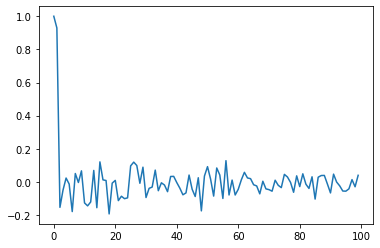

In [9]:
plt.plot(initial_t_s_pacf_r)

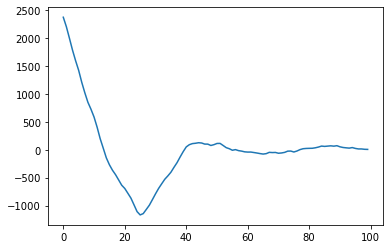

In [10]:
plt.plot(autocorr(t_s))

# AR(1)

In [12]:
def get_complete_stats(y_true, y_pred, model_params):
    print(pd.Series({
                     'akaike': akkake_criteria(y_true, y_pred, model_params),
                     'rmse': rmse(y_true, y_pred, model_params),
                     'durbin watson':durbin_watson(y_true-y_pred),
                     'determination coef':determination_coef(y_true, y_pred),
                     'schwarz criteria': shwarz_criteria(y_true, y_pred, model_params),
                     'rsse': rsse(y_true, y_pred),
                     'adjusted det coef': adjusted_det_coef(y_true, y_pred, model_params),
                     'log likelihood': log_likelihood(y_true, y_pred),
                     'mean dependent var': mean_dependent_var(y_true, y_pred),
                     'std dependent var': std_dependent_var(y_true, y_pred),
                     'sum squared resid': ((y_true - y_pred)**2).sum()
                    }))

In [13]:
ar_model = AR(t_s)
ar_model = ar_model.fit(1)
ar_predict = ar_model.predict(1, len(t_s))

AR coefs:
 [0.06218526 0.94387262]


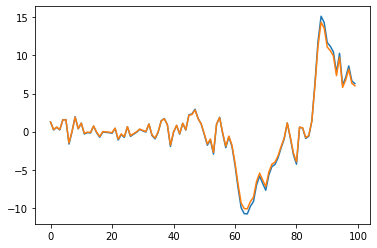

In [14]:
print('AR coefs:\n {}'.format(ar_model.params))

plt.plot(t_s)
plt.plot(ar_predict)
plt.show()

In [15]:
ar_model.params

array([0.06218526, 0.94387262])

In [16]:
get_complete_stats(t_s, ar_predict, len(ar_model.params))

akaike                 0.313258
rmse                   0.280212
durbin watson          0.122060
determination coef     0.890896
schwarz criteria       0.365361
rsse                   7.694846
adjusted det coef      0.789441
log likelihood       -13.662883
mean dependent var    -0.047403
std dependent var      0.273316
sum squared resid      7.694846
dtype: float64


In [17]:
residials_s = t_s - ar_predict
residials_s_quad = residials_s**2

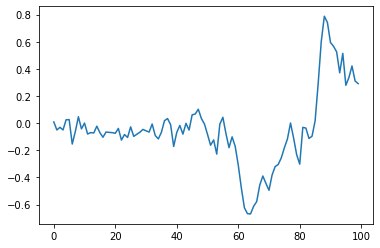

In [18]:
plt.plot(residials_s)

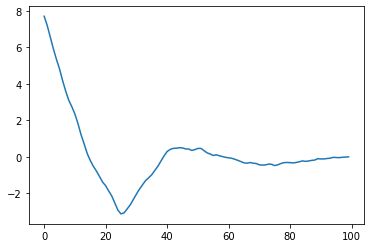

In [19]:
plt.plot(autocorr(residials_s))

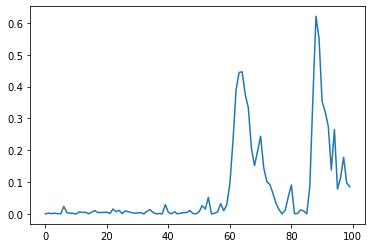

In [20]:
plt.plot(residials_s_quad)

# Explore residuals

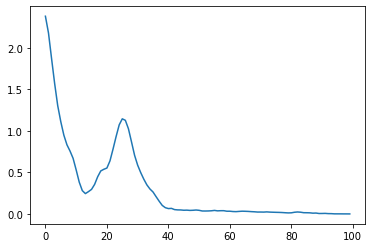

In [21]:
plt.plot(autocorr(residials_s_quad))

# AR(1) on residuals^2

In [22]:
ar_model = AR(residials_s_quad)
ar_model = ar_model.fit(1)
ar_predict_residuals = ar_model.predict(1, len(residials_s_quad))

AR coefs:
 [0.0095084 0.8874695]


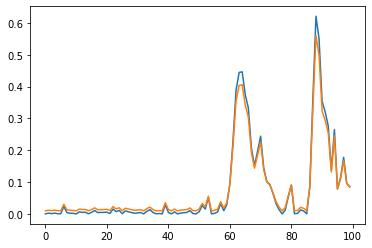

In [23]:
print('AR coefs:\n {}'.format(ar_model.params))

plt.plot(residials_s_quad)
plt.plot(ar_predict_residuals)
plt.show()

In [24]:
get_complete_stats(residials_s_quad, ar_predict_residuals, len(ar_model.params))

akaike                 -5.512586
rmse                    0.015220
durbin watson           0.221087
determination coef      0.787602
schwarz criteria       -5.460482
rsse                    0.022702
adjusted det coef       0.612489
log likelihood        277.629278
mean dependent var     -0.000849
std dependent var       0.015043
sum squared resid       0.022702
dtype: float64


#  AR(4) on residuals^2

In [25]:
ar_model = AR(residials_s_quad)
ar_model = ar_model.fit(4)
ar_predict_residuals_4 = ar_model.predict(4, len(residials_s_quad))

AR coefs:
 [ 0.01304112  1.19497146 -0.38370202  0.09843587 -0.06822867]


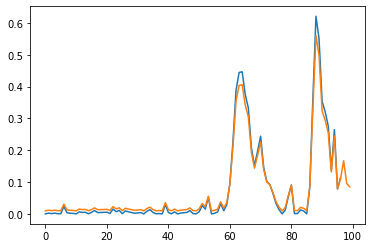

In [26]:
print('AR coefs:\n {}'.format(ar_model.params))

plt.plot(residials_s_quad[:-3])
plt.plot(ar_predict_residuals)
plt.show()

In [27]:
get_complete_stats(residials_s_quad[:-3], ar_predict_residuals_4, len(ar_model.params))

akaike                -1.066676
rmse                   0.138434
durbin watson          0.564367
determination coef     0.807716
schwarz criteria      -0.933959
rsse                   1.763085
adjusted det coef      0.633307
log likelihood        56.733778
mean dependent var    -0.004551
std dependent var      0.134742
sum squared resid      1.763085
dtype: float64


# Conditional dispersion

In [28]:
def count_y_hat(time_s, k):
    if k == 0:
        raise ValueError('Tu cho tvocrich!')
    return (1/k) * sum(time_s[:k+1])

def count_cond_dispersion(time_s, k):
    if k == 0:
        raise ValueError('Tu cho tvocrich!')
    return (1/k) * sum((time_s[:k+1]-count_y_hat(time_s, k))**2)

In [29]:
dispersions = [count_cond_dispersion(t_s, i) for i in range(1,len(t_s))]

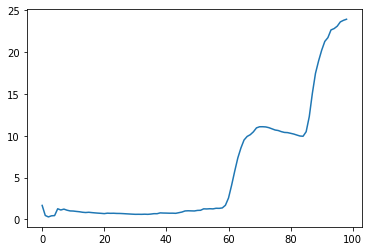

In [30]:
plt.plot(dispersions);

# Find p and q

In [31]:
ar_predict_residuals_4_pacf = PACF(ar_predict_residuals_4)
dispersions_pacf = PACF(dispersions)

ar_predict_residuals_4_pacf_r = [abs(ar_predict_residuals_4_pacf.simmetric_F(i)) for i in range(50)]
dispersions_pacf_r = [abs(dispersions_pacf.simmetric_F(i)) for i in range(50)]

21


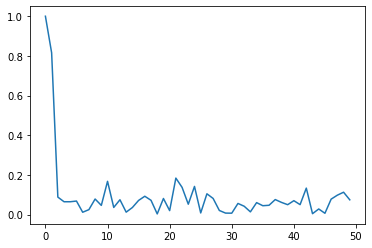

In [32]:
plt.plot(ar_predict_residuals_4_pacf_r);
p = np.max(np.arange(len(ar_predict_residuals_4_pacf_r))[np.array(ar_predict_residuals_4_pacf_r) > 0.15])
print(p)

2


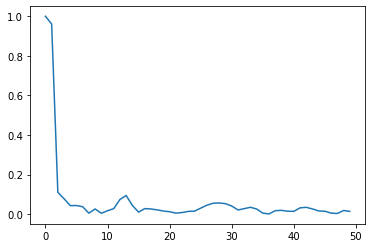

In [33]:
plt.plot(dispersions_pacf_r);
q = np.max(np.arange(len(dispersions_pacf_r))[np.array(dispersions_pacf_r) > 0.1])
print(q)

# DO MNK

In [34]:
df = pd.DataFrame({
    'ar_predict_residuals_4':ar_predict_residuals_4
})

In [35]:
for i in range(p):
    df['ar_predict_residuals_4_lag_{}'.format(i+1)] = df.shift(periods=i+1)['ar_predict_residuals_4']

In [36]:
df['dispersions'] = dispersions[2:]

In [37]:
for i in range(q):
    df['dispersions_lag_{}'.format(i+1)] = df.shift(periods=i+1)['dispersions']

In [38]:
df = df.iloc[max(p,q):, :].reset_index(drop=True)

In [39]:
ss = StandardScaler()

df = pd.DataFrame( 
    columns=df.columns, 
    data=ss.fit_transform(X=df)
    )

In [40]:
X, y = df.drop(columns='dispersions'), df['dispersions']

In [41]:
log_reg = LinearRegression()

log_reg.fit(X,y)
y_hat = log_reg.predict(X)

In [42]:
log_reg.intercept_, log_reg.coef_

(2.0476336377985058e-16,
 array([ 6.01026095e-02, -1.59956580e-02, -1.19964144e-02, -4.62666905e-03,
        -9.69874641e-05, -7.28758342e-03,  3.53798218e-03, -4.37282372e-03,
        -2.66591123e-03,  2.48405120e-03, -1.06721383e-02,  3.03407528e-03,
         4.27789446e-03, -1.11841376e-03, -4.26591925e-03,  1.93407099e-03,
        -2.63069423e-03,  3.71858450e-04,  5.62249581e-04, -4.70576576e-03,
         2.22548068e-04,  3.37053400e-03,  1.54477114e+00, -5.44965338e-01]))

In [43]:
df = df * ss.scale_ + ss.mean_
y_hat = y_hat * ss.scale_[list(df.columns).index('dispersions')] + ss.mean_[list(df.columns).index('dispersions')]

In [44]:
df['dispersion_hat'] = y_hat

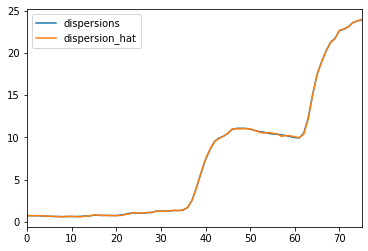

In [45]:
df[['dispersions','dispersion_hat']].plot()

In [46]:
get_complete_stats(df['dispersions'], df['dispersion_hat'], len(log_reg.coef_)+1)

akaike               -2.479755e+00
rmse                  6.152512e-02
durbin watson         1.636759e+00
determination coef    9.999542e-01
schwarz criteria     -1.713067e+00
rsse                  1.930524e-01
adjusted det coef     9.998626e-01
log likelihood        1.192307e+02
mean dependent var   -1.519253e-16
std dependent var     5.073491e-02
sum squared resid     1.930524e-01
dtype: float64


# Geteroskedic process

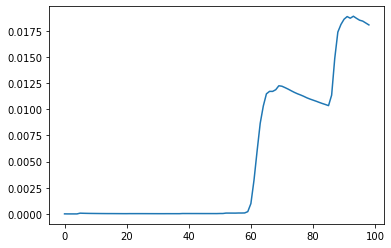

In [47]:
dispersions = [count_cond_dispersion(residials_s_quad, i) for i in range(1,len(residials_s_quad))]
plt.plot(dispersions);

In [48]:
residials_s_quad_pacf = PACF(residials_s_quad)
dispersions_pacf = PACF(dispersions)

residials_s_quad_pacf_r = [abs(residials_s_quad_pacf.simmetric_F(i)) for i in range(50)]
dispersions_pacf_r = [abs(dispersions_pacf.simmetric_F(i)) for i in range(50)]

21


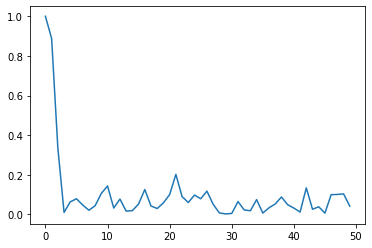

In [49]:
plt.plot(residials_s_quad_pacf_r);
p = np.max(np.arange(len(residials_s_quad_pacf_r))[np.array(residials_s_quad_pacf_r) > 0.15])
print(p)

2


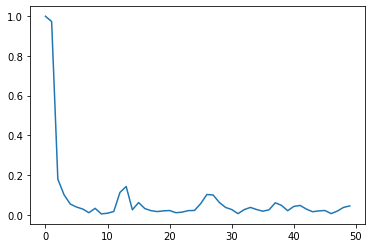

In [50]:
plt.plot(dispersions_pacf_r);
q = np.max(np.arange(len(dispersions_pacf_r))[np.array(dispersions_pacf_r) > 0.15])
print(q)

In [51]:
df = pd.DataFrame({
    'residials_s_quad':residials_s_quad
})

In [52]:
for i in range(p):
    df['residials_s_quad_lag_{}'.format(i+1)] = df.shift(periods=i+1)['residials_s_quad']

In [53]:
df['dispersions'] = [np.nan] + dispersions

In [54]:
for i in range(q):
    df['dispersions_lag_{}'.format(i+1)] = df.shift(periods=i+1)['dispersions']

In [55]:
df = df.iloc[max(p,q+1):, :].reset_index(drop=True)

In [56]:
ss = StandardScaler()

df = pd.DataFrame( 
    columns=df.columns, 
    data=ss.fit_transform(X=df)
    )

In [57]:
X, y = df.drop(columns='dispersions'), df['dispersions']

In [58]:
log_reg = LinearRegression()

log_reg.fit(X,y)
y_hat = log_reg.predict(X)

In [59]:
log_reg.intercept_, log_reg.coef_

(-8.354493520262974e-17,
 array([ 1.09240751e-01, -2.73647871e-02, -2.98281410e-02, -1.52378124e-03,
         8.26249006e-04, -7.84094224e-03,  2.41230017e-02, -4.34433522e-02,
         5.04941704e-02, -2.14605004e-02, -2.75406581e-02,  4.30565505e-02,
        -2.59338264e-02,  3.86885051e-02, -4.45037534e-02,  3.45088090e-02,
         6.50296980e-03, -6.32001112e-02,  5.24038186e-02,  6.09370485e-03,
        -1.51413218e-02, -4.02430121e-04,  1.42703236e+00, -4.52834978e-01]))

In [60]:
df = df * ss.scale_ + ss.mean_
y_hat = y_hat * ss.scale_[list(df.columns).index('dispersions')] + ss.mean_[list(df.columns).index('dispersions')]

In [61]:
df['dispersion_hat'] = y_hat

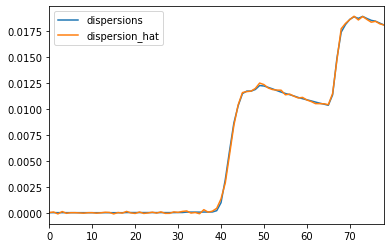

In [62]:
df[['dispersions','dispersion_hat']].plot()

In [63]:
get_complete_stats(df['dispersions'], df['dispersion_hat'], len(log_reg.coef_)+1)

akaike               -1.457323e+01
rmse                  1.460181e-04
durbin watson         1.816214e+00
determination coef    9.997031e-01
schwarz criteria     -1.382341e+01
rsse                  1.151350e-06
adjusted det coef     9.991261e-01
log likelihood        6.006428e+02
mean dependent var    3.458468e-19
std dependent var     1.214944e-04
sum squared resid     1.151350e-06
dtype: float64
